In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from PIL import Image


<p> QUESTION 19: In a brief paragraph discuss: If the VGG network is trained on a dataset with
perhaps totally different classes as targets, why would one expect the features derived from such a
network to have discriminative power for a custom dataset? </p>
</br>
A: One might anticipate that features obtained from a VGG would exhibit strong discriminative capabilities for a custom dataset, owing to its robust ability to intricately capture and differentiate details across images. VGG, a Convolutional Neural Network (CNN) architecture, is designed to enhance network depth through the utilization of simple and uniform convolutional layers, contributing to its effectiveness. The increased depth allows VGG to systematically capture and organize a hierarchy of features, encompassing a spectrum of complexities, ranging from fundamental edges and shapes to more elaborate textures and patterns. Another rationale for augmenting the depth lies in the recognition that visual data encompasses features at various levels of abstraction. Consequently, by emphasizing deeper networks, VGG is better positioned to encapsulate the essence of images and discern subtle distinctions within them.


# Flowers Dataset and VGG Features

![image.png](attachment:image.png)

In [2]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16

            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out)
            return out

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 97.6MB/s]
100%|██████████| 58/58 [00:34<00:00,  1.67it/s]


<p>QUESTION 20: In a brief paragraph explain how the helper code base is performing feature
extraction.</p>
</br>
A: The helper code executes feature extraction through a sequence of steps. Initially, it loads the dataset. Subsequently, it instantiates an object of the 'FeatureExtractor' class, responsible for the actual feature extraction process. The code then transforms the dataset images to prepare them for the feature extraction method, storing them in a Dataloader. Lastly, the code iterates through the Dataloader, employing the 'FeatureExtractor' instance to extract features from each batch of images. These extracted features are then saved onto the disk. Notably, the 'FeatureExtractor' class utilizes the VGG16 model, leveraging its convolutional layers, average pooling, flattening, and the initial fully-connected layer to capture hierarchical image features from the dataset.


<p>QUESTION 21: How many pixels are there in the original images? How many features does
the VGG network extract per image; i.e what is the dimension of each feature vector for an image
sample?</p>
</br>
A: The original images possess varying pixel dimensions, but they are uniformly resized to 224x224 pixels before undergoing feature extraction using VGG16. Following the feature extraction process, a feature vector of dimensions 4096 is generated for each image sample. In essence, the VGG16 network extracts 4096 features for every image, providing a comprehensive representation of the image content.


In [3]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
sparsity = np.sum(f_all == 0) / len(f_all)
print(sparsity)

(3670, 4096) (3670,)
0.0


<p>QUESTION 22: Are the extracted features dense or sparse? (Compare with sparse TF-IDF
features in text.)</p>
</br>
A: The sparsity value I computed for the features extracted from VGG16 is 0.0, indicating high density. However, when evaluating the sparsity of TF-IDF features in text, the result is 0.9824, indicating significant sparsity.

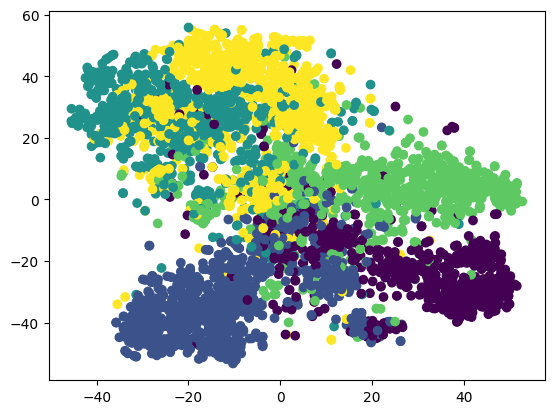

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(f_all)
plt.scatter(*tsne_result.T, c=y_all)

<p>QUESTION 23: In order to inspect the high-dimensional features, t-SNE is a popular off-the-shelf
choice for visualizing Vision features. Map the features you have extracted onto 2 dimensions with
t-SNE. Then plot the mapped feature vectors along x and y axes. Color-code the data points with
ground-truth labels. Describe your observation.</p>
</br>
A: It appears that there are 5 distinct classes or labels, as evidenced by the presence of 5 different colored points (cyan, yellow, blue, green, and purple) on the graph. The blue, purple, and green clusters exhibit clear boundaries, while the yellow and cyan clusters seem to be partially mixed. This suggests potential similarities between the yellow and cyan data points or labels. Additionally, if clusters were outlined, they would take on an oval shape, indicating that the data points within each cluster may display some degree of elongation or directionality.

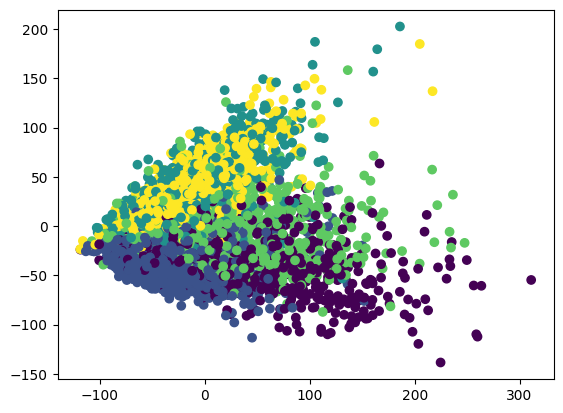

In [6]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True),
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()


    def forward(self, X):
        return self.model(X)

    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()

        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                optimizer.zero_grad()
                outputs = self(X_)
                loss = criterion(outputs, y_)
                loss.backward()
                optimizer.step()
        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        self.model.eval()
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y_test = torch.tensor(y_test, dtype=torch.int64, device='cuda')
        with torch.no_grad():
            outputs = self(X_test)
        _, predictions = torch.max(outputs, 1)
        correct = (predictions == y_test).sum().item()
        total = y_test.size(0)
        accuracy = correct / total
        return accuracy

# Autoencoder

In [8]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components, n_features=None):
        super().__init__()
        self.n_components = n_components
        self.n_features = n_features  # to be determined with data
        self.encoder = None
        self.decoder = None

    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))

    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))

    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


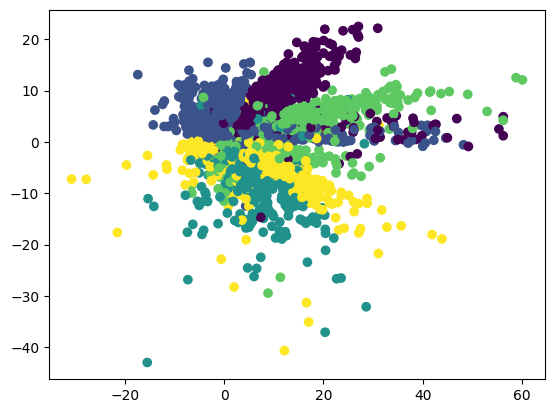

In [9]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [10]:
!pip install umap-learn
!pip install hdbscan
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score
from itertools import product

def rand_score_calc_for_diff_clusterer(embedding, y_all):
    rand_scores = {}

    kmeans = KMeans(n_clusters=5, n_init='auto')
    kmeans_labels = kmeans.fit_predict(embedding)
    rand_scores['kmeans'] = adjusted_rand_score(y_all, kmeans_labels)

    agg_clustering = AgglomerativeClustering(n_clusters=5)
    agg_labels = agg_clustering.fit_predict(embedding)
    rand_scores['agglomerative'] = adjusted_rand_score(y_all, agg_labels)

    best_hdbscan_score = 0.0
    best_hdbscan_params = {}

    params_combinations = product([10, 50, 100, 200], [1, 5, 10, 20])
    for min_cluster_size, min_samples in params_combinations:
        hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples).fit_predict(embedding)
        hdbscan_score = adjusted_rand_score(y_all, hdbscan_labels)

        if hdbscan_score > best_hdbscan_score:
            best_hdbscan_score = hdbscan_score
            best_hdbscan_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}

    rand_scores['hdbscan'] = (best_hdbscan_score, best_hdbscan_params)
    return rand_scores


f_all_svd = TruncatedSVD(n_components=50).fit_transform(f_all)
f_all_umap = umap.UMAP(n_components=50).fit_transform(f_all)
f_all_autoencoder = Autoencoder(2, 50).fit_transform(f_all)

print("Rand score of clustering w/o dimensionality reduction:")
print(rand_score_calc_for_diff_clusterer(f_all, y_all))
print("Rand score of clustering with SVD:")
print(rand_score_calc_for_diff_clusterer(f_all_svd, y_all))
print("Rand score of clustering with UMAP:")
print(rand_score_calc_for_diff_clusterer(f_all_umap, y_all))
print("Rand score of clustering with Autoencoder:")
print(rand_score_calc_for_diff_clusterer(f_all_autoencoder, y_all))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=882daaa374796409b256d9654e6b4a2ea4380f74ddfb35f6d12f7ab38d6c1680
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039281 sha256=844c3fb21170f54cfbe2e927830bcfd2eb631be4e671198f98e00395f733beec
  S

100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Rand score of clustering w/o dimensionality reduction:
{'kmeans': 0.19635566765122872, 'agglomerative': 0.2184499487113686, 'hdbscan': (0.015014212771105666, {'min_cluster_size': 10, 'min_samples': 1})}
Rand score of clustering with SVD:
{'kmeans': 0.2098699434994347, 'agglomerative': 0.16422464508301501, 'hdbscan': (0.02643295458142522, {'min_cluster_size': 10, 'min_samples': 1})}
Rand score of clustering with UMAP:
{'kmeans': 0.39981871984057604, 'agglomerative': 0.3862922170893482, 'hdbscan': (0.4167541162586394, {'min_cluster_size': 100, 'min_samples': 1})}
Rand score of clustering with Autoencoder:
{'kmeans': 0.22650562888522663, 'agglomerative': 0.21755943468455324, 'hdbscan': (0.11194370301529104, {'min_cluster_size': 100, 'min_samples': 5})}


<p>QUESTION 24: Report the best result (in terms of rand score) within the table below.
For HDBSCAN, introduce a conservative parameter grid over min cluster size and min samples.</p>
</br>
A: The combination of dimensionality reduction and clustering with the best rand score is UMAP dimensionality reduction with n_components = 50 and HDBScan clustering with min_cluster_size = 100 & min_samples = 1. Their rand score is 0.4167541162586394.

In [17]:
from sklearn.model_selection import train_test_split
import umap

# Split the data
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2, random_state=0)

# Train MLP on original features
mlp = MLP(X_train.shape[1])
mlp.train(X_train, y_train)
accuracy_score = mlp.eval(X_test, y_test)
print("Original VGG features test accuracy: ")
print(accuracy_score)

# # Dimensionality reduction using UMAP
umap_X_train_res = umap.UMAP(n_components=50).fit_transform(X_train)
umap_X_test_res = umap.UMAP(n_components=50).fit_transform(X_test)

# Train MLP on reduced-dimension features
mlp_with_reduced_dimension = MLP(umap_X_train_res.shape[1])
mlp_with_reduced_dimension.train(umap_X_train_res, y_train)
mlp_with_reduced_dimension_accuracy_score = mlp_with_dim_red.eval(umap_X_test_result, y_test)
print("Reduced-dimension features (dimensionality reduction using UMAP with n_components = 50) test accuracy: ")
print(mlp_with_reduced_dimension_accuracy_score)


100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


Original VGG features test accuracy: 
0.8950953678474114


100%|██████████| 100/100 [00:06<00:00, 16.00it/s]

Reduced-dimension features (dimensionality reduction using UMAP with n_components = 50) test accuracy: 
0.26430517711171664


<p>QUESTION 25: Report the test accuracy of the MLP classifier on the original VGG features.
Report the same when using the reduced-dimension features (you have freedom in choosing the
dimensionality reduction algorithm and its parameters). Does the performance of the model suffer
with the reduced-dimension representations? Is it significant? Does the success in classification
make sense in the context of the clustering results obtained for the same features in Question 24.</p>
</br>
A: The MLP classifier achieved a test accuracy of 0.8950953678474114 on the original VGG features, whereas the test accuracy dropped significantly to 0.26430517711171664 when using reduced-dimension features (obtained through UMAP with n_components = 50). This decline in performance suggests that the dimensionality reduction process led to a loss of information, as the reduced-dimension features may not fully capture the essential patterns present in the data. The discrepancy in results aligns with the clustering outcomes discussed in Question 24. Clustering, an unsupervised machine learning process operating on unlabeled data, aims to identify patterns without prior knowledge of categories. Consequently, clustering algorithms can make reasonably accurate predictions even in the presence of information loss during dimensionality reduction. In contrast, classification, being a supervised machine learning process, heavily relies on labeled datasets for training. The substantial drop in accuracy after dimensionality reduction highlights the sensitivity of classification models to the loss of valuable information. Supervised learning depends on having access to accurate labels during training, and any loss of relevant features can significantly impact classification performance.







